In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd
import sklearn
import random
import sys
import os
import matplotlib.pyplot as plt
import math
import scipy
from distcorr import distcorr
from fractions import gcd
from scipy.stats import pearsonr
from sklearn import preprocessing
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split

In [37]:
NAN = 0

def fill_nan(array, REPLACE_COUNT):
    array.flat[np.random.choice(array.size, int(REPLACE_COUNT), replace=False)] = NAN

    return array

In [38]:
scaler = preprocessing.MinMaxScaler(feature_range=(0,1))

In [39]:
# ENABLE/DISABLE GPU
# UNCOMMENT to.device() FOR TENSORS AND NEURAL NETWORKS TO ENABLE GPU

if torch.cuda.is_available():
    dev = "cuda:0"
else:
    dev = "cpu"

device = torch.device(dev)

os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

In [40]:
dataset = pd.read_csv('breast/breast.csv')

In [41]:
# NARROW THE FEATURES
array = np.array(['radius_mean', 'perimeter_mean', 'area_mean', 'radius_worst', 'perimeter_worst', 'area_worst'])
processed_data = dataset[array]

In [42]:
# CONVERT TO NUMPY
numpy_data = processed_data.to_numpy()

In [43]:
# NORMALIZE THE DATA
scaled_data = scaler.fit_transform(numpy_data)

In [44]:
average_value = np.mean(scaled_data.flatten())
average_value

0.27313062023503254

In [45]:
full_data = scaled_data.copy()
missing_data = fill_nan(scaled_data.copy(), scaled_data.copy().size*0.2)

In [46]:
bins = np.linspace(0, 10)
y_binned = np.digitize(full_data[:,0], bins)

In [47]:
random.seed(1)
x_train, x_test, y_train, y_test = train_test_split(missing_data.copy(), full_data.copy(), stratify=y_binned, random_state=random.randint(1, 10))

In [48]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        self.enc1 = nn.Linear(in_features=6, out_features=8)
        self.enc2 = nn.Linear(in_features=8, out_features=16)

        self.dec2 = nn.Linear(in_features=16, out_features=8)
        self.dec3 = nn.Linear(in_features=8, out_features=6)

    def forward(self, x):
        x = F.leaky_relu(self.enc1(x))
        x = F.leaky_relu(self.enc2(x))
        x = F.leaky_relu(self.dec2(x))
        x = self.dec3(x)
        return x

In [49]:
# CREATE A SEED FOR CONSISTENT WEIGHT INITIALIZATIONS - FOR TESTING PURPOSES
random.seed(2)
torch.manual_seed(random.randint(1, 10))
net = Autoencoder().double()
#net.to(device)

In [50]:
NUM_EPOCHS = 110
LEARNING_RATE = 0.0001
BATCH_SIZE = -1
NUM_FEATURES = 6
BATCH_SIZE_TEST = -1

In [51]:
x_train = torch.from_numpy(x_train)
#x_train = x_train.to(device)
x_train = x_train.view(BATCH_SIZE, NUM_FEATURES)

y_train = torch.from_numpy(y_train)
#y_train = y_train.to(device)
y_train = y_train.view(BATCH_SIZE, NUM_FEATURES)

x_test = torch.from_numpy(x_test)
#x_test = x_test.to(device)
x_test = x_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

y_test = torch.from_numpy(y_test)
#y_test = y_test.to(device)
y_test = y_test.view(BATCH_SIZE_TEST, NUM_FEATURES)

x_train.shape

torch.Size([426, 6])

In [52]:
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE)

In [53]:
def train(net):
    train_loss = []
    torch.set_printoptions(precision=2, sci_mode=True)
    np.set_printoptions(precision=2, suppress=True)

    for epoch in range(NUM_EPOCHS):
        # running_loss: LOSS OF THE PREDICTED MISSING VALUE ONLY
        # overall_loss: LOSS OF ALL RECONSTRUCTED VALUES

        running_loss = 0.0
        overall_loss = 0.0
        count = 0
        for missing_data, full_data in zip(x_train, y_train):
            optimizer.zero_grad()
            outputs = net(missing_data.double())

            # LEARN FROM LOSS OF ALL RECONSTRUCTED VALUES
            loss = criterion(outputs, full_data)
            loss.backward()
            optimizer.step()
            overall_loss += loss.item()
            
            # COMPUTE LOSS OF PREDICTED MISSING VALUE
            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            # PRINT ALL VALUES ON LAST EPOCH FOR TESTING PURPOSES
            if epoch == NUM_EPOCHS-1:
                if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                    print("Input: ", scaler.inverse_transform(missing_data.reshape(-1,6)))
                    print("Target: ", scaler.inverse_transform(full_data.reshape(-1,6)))
                    print("Outputs: ", scaler.inverse_transform(outputs.reshape(-1,6).detach().numpy()))
                else:
                    print("Input (missing): ", scaler.inverse_transform(missing_data.reshape(-1,6)))
                    print("Target (missing): ", scaler.inverse_transform(full_data.reshape(-1,6)))
                    print("Outputs (missing): ", scaler.inverse_transform(outputs.reshape(-1,6).detach().numpy()))
        
      #  loss = running_loss / count
        overall_loss = overall_loss / len(x_train)
        x_loss = running_loss / count
        train_loss.append(loss)

        print('Epoch {} of {}, Train Loss: {:.5f}, Overall: {:.5f}'
             .format(epoch+1, NUM_EPOCHS, x_loss, overall_loss))

    return train_loss


def test(net):

    net.eval()
    count = 0

    with torch.no_grad():
        test_loss = []
        running_loss = 0.0
        overall_loss = 0.0

        for missing_data, full_data in zip(x_test, y_test):
            outputs = net(missing_data.double())

            loss = criterion(outputs, full_data)
            overall_loss += loss.item()

            if NAN in missing_data:
                for index in range(len(missing_data)):
                    if missing_data[index] == NAN:
                        predicted_loss = criterion(outputs[index], full_data[index])
                        running_loss += predicted_loss.item()
                        count += 1
            
            if missing_data.detach().numpy().all() == full_data.detach().numpy().all():
                print("Input: ", scaler.inverse_transform(missing_data.reshape(-1,6)))
                print("Target: ", scaler.inverse_transform(full_data.reshape(-1,6)))
                print("Outputs: ", scaler.inverse_transform(outputs.reshape(-1,6).detach().numpy()))
            else:
                print("Input (missing): ", scaler.inverse_transform(missing_data.reshape(-1,6)))
                print("Target (missing): ", scaler.inverse_transform(full_data.reshape(-1,6)))
                print("Outputs (missing): ", scaler.inverse_transform(outputs.reshape(-1,6).detach().numpy()))

        overall_loss = running_loss / len(x_test)
        x_loss = running_loss / count
        test_loss.append(overall_loss)
        print('Test Loss: {:.5f}, Overall: {:.5f}'.format(x_loss, overall_loss))

        return test_loss

In [26]:
# TRAIN THE NEURAL NETWORK
results = train(net)

  150.77 1606.14]]
Input (missing):  [[   6.98  152.8  1509.     28.4   206.8   185.2 ]]
Target (missing):  [[  22.27  152.8  1509.     28.4   206.8  2360.  ]]
Outputs (missing):  [[  20.9   137.16 1290.6    24.81  173.17 1922.15]]
Input (missing):  [[  6.98  76.77 442.5   13.09  85.07 523.7 ]]
Target (missing):  [[ 12.    76.77 442.5   13.09  85.07 523.7 ]]
Outputs (missing):  [[ 12.12  77.82 448.64  13.36  88.68 552.29]]
Input (missing):  [[  6.98  43.79 646.1    7.93 100.4  734.6 ]]
Target (missing):  [[ 14.4   92.25 646.1   15.4  100.4  734.6 ]]
Outputs (missing):  [[ 11.5   73.4  384.93  12.5   82.83 457.23]]
Input (missing):  [[  6.98  78.78 462.     7.93  87.65 529.9 ]]
Target (missing):  [[ 12.21  78.78 462.    13.13  87.65 529.9 ]]
Outputs (missing):  [[ 12.43  80.26 497.51  14.02  91.98 629.74]]
Input (missing):  [[  6.98  69.14 363.7   11.37  72.42 392.2 ]]
Target (missing):  [[ 10.91  69.14 363.7   11.37  72.42 392.2 ]]
Outputs (missing):  [[ 11.12  71.28 358.83  12.19  78.

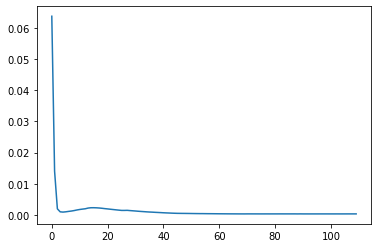

In [52]:
plt.plot(results)

In [31]:
# TEST THE NEURAL NETWORK
test_result = test(net)

.4  671.4   16.08 118.6  784.7 ]]
Target:  [[ 14.86 100.4  671.4   16.08 118.6  784.7 ]]
Outputs:  [[  15.14   98.54  735.57   17.44  116.94 1025.82]]
Input (missing):  [[  6.98  85.24 143.5   14.2   92.94 621.2 ]]
Target (missing):  [[ 13.3   85.24 546.1   14.2   92.94 621.2 ]]
Outputs (missing):  [[ 12.35  79.53 473.23  13.72  91.15 585.99]]
Input (missing):  [[ 11.3   73.93 389.4   12.58  50.41 472.9 ]]
Target (missing):  [[ 11.3   73.93 389.4   12.58  87.16 472.9 ]]
Outputs (missing):  [[ 11.64  75.08 413.5   12.96  83.81 486.83]]
Input (missing):  [[  6.98  81.92 485.8   13.37  89.02 547.4 ]]
Target (missing):  [[ 12.56  81.92 485.8   13.37  89.02 547.4 ]]
Outputs (missing):  [[ 12.51  80.51 482.08  13.86  92.52 604.32]]
Input (missing):  [[ 14.48  43.79 648.2   16.21 108.4  808.9 ]]
Target (missing):  [[ 14.48  94.25 648.2   16.21 108.4  808.9 ]]
Outputs (missing):  [[ 14.42  94.05 675.96  16.73 109.22 935.53]]
Input (missing):  [[ 11.32  71.76 395.7    7.93  79.82 452.3 ]]
Targe

In [64]:
torch.save(net, './model3')

# The following section is for reconstructing a brand new dataset from an input dataset that has missing values.
# This new dataset can be used in some classifiers to see if the accuracy changes.

In [54]:
my_model = torch.load('model3')
my_model

Autoencoder(
  (enc1): Linear(in_features=6, out_features=8, bias=True)
  (enc2): Linear(in_features=8, out_features=16, bias=True)
  (dec2): Linear(in_features=16, out_features=8, bias=True)
  (dec3): Linear(in_features=8, out_features=6, bias=True)
)

In [55]:
predicted_set = my_model(x_test.double())
predicted_set = scaler.inverse_transform(predicted_set.detach().numpy())

x_test_inverse = scaler.inverse_transform(x_test.detach().numpy())
y_test_inverse = scaler.inverse_transform(y_test.detach().numpy())

In [56]:
real_values = []
predicted_values = []
x_values = []

for missing_data, full_data, predicted in zip(x_test, y_test_inverse, predicted_set):
    if NAN in missing_data:
        for i in range(len(missing_data)):
            if missing_data[i] == NAN:
                x_values.append(full_data[0].item())
                real_values.append(full_data[i].item())
                predicted_values.append(predicted[i].item())

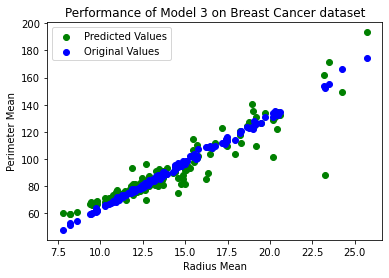

In [57]:
plt.scatter(y_test_inverse[:, 0], predicted_set[:, 1], color='green', label='Predicted Values')
plt.scatter(y_test_inverse[:, 0], y_test_inverse[:, 1], color='blue', label='Original Values')
plt.xlabel('Radius Mean')
plt.ylabel('Perimeter Mean')
plt.legend()
plt.title('Performance of Model 3 on Breast Cancer dataset')
plt.show()

In [58]:
from scipy import stats
from statsmodels.stats import weightstats as stets

p_values = []
t_values = []

for i in range(6):
    ttest, pval = stats.ttest_ind(y_test_inverse[:, i], predicted_set[:, i])
    print("P-value for significance: ", pval)
    print("TTEST: ", ttest)
    p_values.append(pval)
    t_values.append(ttest)

    if pval<0.05:
        print("Conclusion: Reject Null Hypothesis")
    else:
        print("Conclusion: Accept Null Hypothesis")

print("Mean P-Value: ", np.mean(p_values))
print("Mean T-Value: ", np.mean(t_values))

P-value for significance:  0.832548763951866
TTEST:  0.21162836916064282
Conclusion: Accept Null Hypothesis
P-value for significance:  0.8845588307658174
TTEST:  0.14532313872939767
Conclusion: Accept Null Hypothesis
P-value for significance:  0.8279495728376431
TTEST:  0.21753251648692878
Conclusion: Accept Null Hypothesis
P-value for significance:  0.7192680725689691
TTEST:  0.3597946924075535
Conclusion: Accept Null Hypothesis
P-value for significance:  0.8006351810952268
TTEST:  0.2527617447180939
Conclusion: Accept Null Hypothesis
P-value for significance:  0.8171942205972481
TTEST:  0.23136968502405428
Conclusion: Accept Null Hypothesis
Mean P-Value:  0.8136924403027951
Mean T-Value:  0.2364016910877785


In [59]:
for i in range(1, 6):
    print("Original Column: ", i, scipy.stats.pearsonr(y_test_inverse[:, 0], y_test_inverse[:, i]))
    print("Predicted Column: ", i, scipy.stats.pearsonr(y_test_inverse[:, 0], predicted_set[:, i]))

Original Column:  1 (0.9983931169534304, 1.114667394287213e-177)
Predicted Column:  1 (0.9236893112571709, 1.3010532865748473e-60)
Original Column:  2 (0.9895702378986968, 1.5202808901099828e-120)
Predicted Column:  2 (0.9262280768996065, 1.3108629522396572e-61)
Original Column:  3 (0.9707682913942353, 2.8430729866552097e-89)
Predicted Column:  3 (0.9271194217607892, 5.7427621124302615e-62)
Original Column:  4 (0.9658429568626401, 1.4027698130338616e-84)
Predicted Column:  4 (0.9205861684944654, 1.935140076968822e-59)
Original Column:  5 (0.9516422185313183, 3.765860492774868e-74)
Predicted Column:  5 (0.9259935453984534, 1.6260024053850906e-61)
